In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import lite
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.metrics import Precision, Recall
from keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [2]:
batch_size = 32
image_height = 512
image_width = 512
epoch = 48

In [3]:
train_path = 'Brain/train'
test_path = 'Brain/test'
val_path = 'Brain/val'

In [4]:
def plotting_images(item_dir, num_imgs=5):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.axis('off')
        plt.imshow(img)

    plt.tight_layout()

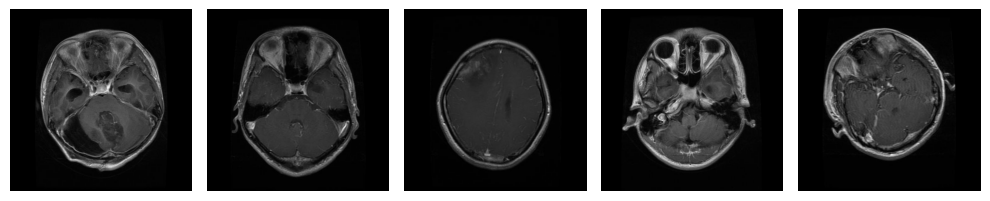

In [5]:
plotting_images("Brain/train/Glioma")

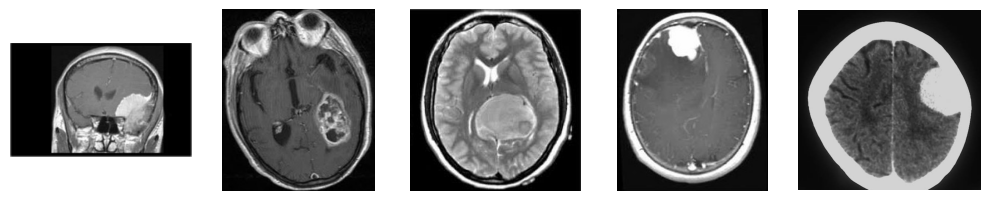

In [6]:
plotting_images("Brain/train/Meningioma")

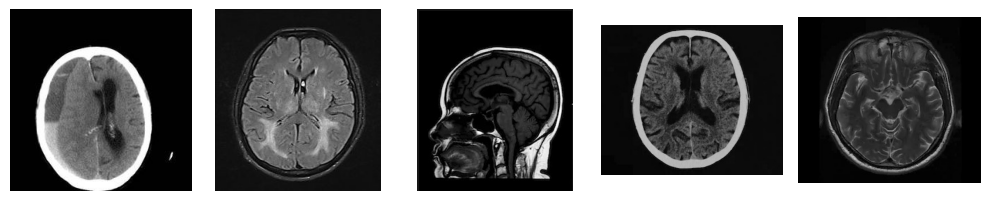

In [7]:
plotting_images("Brain/train/Notumor")

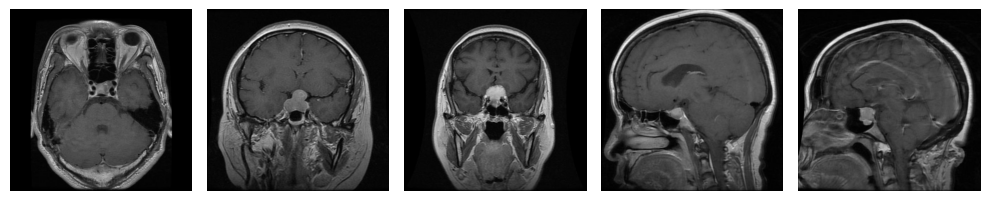

In [8]:
plotting_images("Brain/train/Pituitary")

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [10]:
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(image_height, image_width),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size= batch_size,
                                                  )

test_dataset = test_datagen.flow_from_directory(test_path,
                                                target_size=(image_height, image_width),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size= batch_size,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory(val_path,
                                                  target_size=(image_height, image_width),
                                                  class_mode='categorical',
                                                  batch_size= batch_size,
                                                  color_mode='grayscale',
                                                  )

Found 5617 images belonging to 4 classes.
Found 704 images belonging to 4 classes.
Found 702 images belonging to 4 classes.


In [11]:
checkpoint = ModelCheckpoint("Training_data_Brain-Tumor-1.h5", mode='auto', save_freq=1)

In [12]:
model = Sequential([
  
    Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=train_dataset.image_shape), 
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax'),
 
])

In [13]:
METRICS = [
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [14]:
model_fit = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch=10,
                      epochs = epoch,
                      callbacks=[checkpoint])

Epoch 1/48
10/10 [==============================] - 148s 16s/step - loss: 1.5993 - accuracy: 0.2313 - precision: 0.1515 - recall: 0.0156 - val_loss: 1.3470 - val_accuracy: 0.3362 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/48
10/10 [==============================] - 174s 18s/step - loss: 1.5581 - accuracy: 0.3719 - precision: 0.5185 - recall: 0.0875 - val_loss: 1.1607 - val_accuracy: 0.3490 - val_precision: 0.9097 - val_recall: 0.2009
Epoch 3/48
10/10 [==============================] - 212s 22s/step - loss: 1.1992 - accuracy: 0.4031 - precision: 0.6667 - recall: 0.1187 - val_loss: 0.9952 - val_accuracy: 0.5541 - val_precision: 0.9139 - val_recall: 0.1966
Epoch 4/48
10/10 [==============================] - 108s 11s/step - loss: 1.1648 - accuracy: 0.5562 - precision: 0.5965 - recall: 0.2125 - val_loss: 1.1522 - val_accuracy: 0.4929 - val_precision: 0.2286 - val_recall: 0.0114
Epoch 5/48
10/10 [==============================] - 112s 11s/step - loss: 1.0583 - accuracy: 0.5

In [15]:
model.save('Training_data_Brain-Tumor-1.h5')

In [16]:
tf_model = load_model("Training_data_Brain-Tumor-1.h5")
converter = lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("Training_data_Brain-Tumor_lite.tflite", 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\VISHAL~1\AppData\Local\Temp\tmpv463ojcx\assets


INFO:tensorflow:Assets written to: C:\Users\VISHAL~1\AppData\Local\Temp\tmpv463ojcx\assets


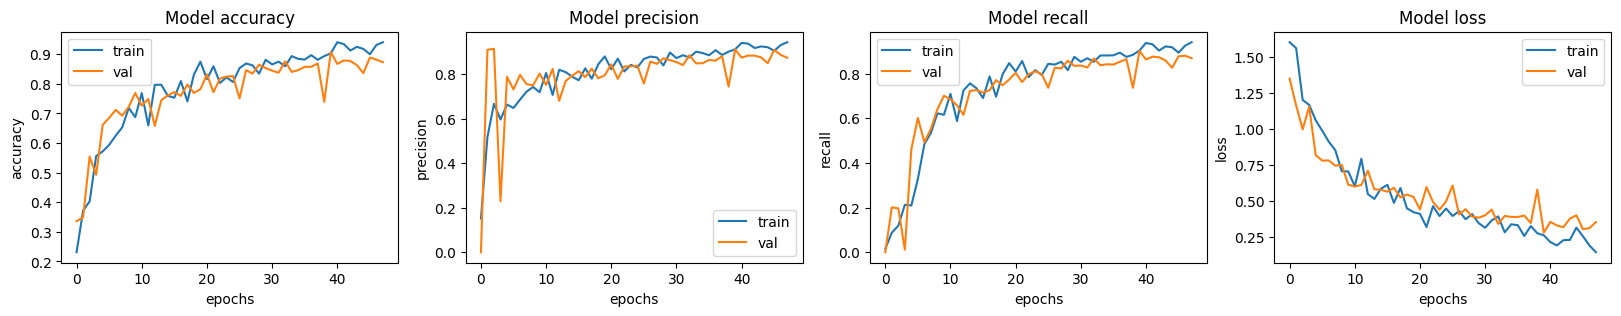

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy','precision','recall', 'loss']):
    ax[i].plot(model_fit.history[met])
    ax[i].plot(model_fit.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [18]:
predictions = model.predict(test_dataset)

22/22 [==============================] - 36s 2s/step


In [19]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [20]:
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(5,5))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 0.8977272727272727
Precision: 0.908143203347539
Recall: 0.8931031557910392
F1_score: 0.8930250320098643


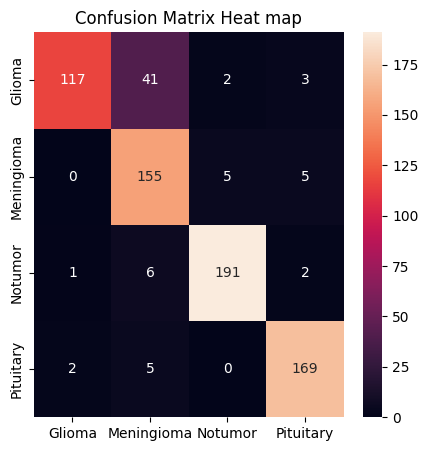

In [21]:
evaluate(test_dataset.classes,predictions)

In [22]:
model.evaluate(test_dataset)

22/22 [==============================] - 36s 2s/step - loss: 0.3162 - accuracy: 0.8977 - precision: 0.8999 - recall: 0.8935


[0.3161661922931671,
 0.8977272510528564,
 0.8998569250106812,
 0.8934659361839294]